In [34]:
from aicsimageio import AICSImage, readers
import zarr
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from matplotlib import rc

In [3]:
im_dir = r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_24-dpt-gfp_r4-gal4_uas-mcd8-mcherry_noInjCtl_lateL3/rhodamine/scan_1'
assemble_mean_sheet = False

In [4]:
if assemble_mean_sheet:
    sheet_0 = AICSImage(im_dir + '/scan.czi').get_image_data().squeeze().astype('float32')
    sheet_1 = AICSImage(im_dir + '/scan(1).czi').get_image_data().squeeze().astype('float32')
    mean_sheet = 0.5 * (sheet_0 + sheet_1)
    mean_sheet = mean_sheet.astype('uint16')
    mean_sheet_zarr = zarr.array(mean_sheet, chunks=(100, 1920, 1920), store=im_dir + '/mean_sheet.zarr')

In [26]:
# load the scan
mean_sheet = np.array(zarr.open(r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_24-dpt-gfp_r4-gal4_uas-mcd8-mcherry_noInjCtl_lateL3/rhodamine/scan_1' + '/mean_sheet.zarr', 'r'))

In [35]:
rc('axes', linewidth=2)

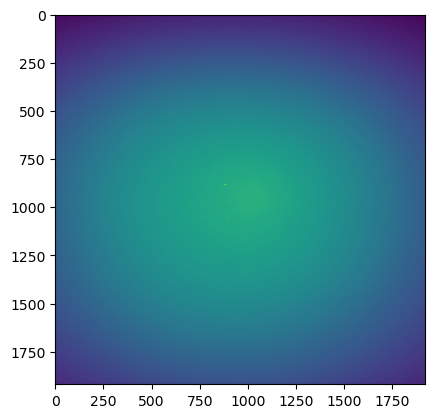

In [27]:
# plot a z plane
plt.imshow(mean_sheet[0])

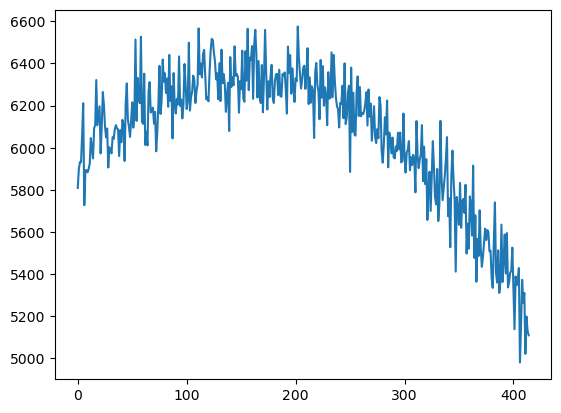

In [28]:
# plot the intensity along z to make sure we're in a stable regime
plt.figure()
plt.plot(mean_sheet[:, 1000, 1000])

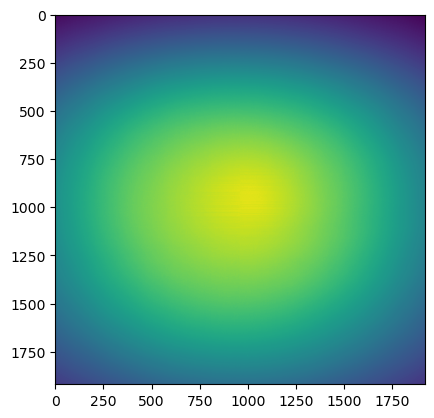

In [29]:
# red
good_planes = [102, 110, 111, 117, 122, 134, 137, 148, 150, 151, 152, 154, 162, 163, 167, 184, 198, 199, 200]
# green
#good_planes = [405, 404, 403, 388, 375, 370, 366, 362, 359, 354, 348, 346, 342, 336, 330, 324, 319]
mean_mean = np.mean(mean_sheet[good_planes], axis=0)
plt.figure()
plt.imshow(mean_mean)

# fitting functions

In [30]:
def fit_sheet(data):
    """Returns params found by a fit"""
    params = get_initial_sheet_param_estimates(data)


    def error_function(p): return np.ravel(
        sheet_intensity(np.indices(data.shape)[1], np.indices(data.shape)[0], p[0], p[1],
                       p[2], p[3], p[4]) - data)

    result = least_squares(error_function, params, bounds=(0, np.inf), method='trf')

    return result


def sheet_intensity(x, y, I0, xc, yc, xR, sigma_y):
    I = I0 * (1 / (1 + ((x-xc) / xR) ** 2)) * np.exp(-0.5 * ((y - yc) / sigma_y) **2)
    
    return I


def get_initial_sheet_param_estimates(data):
    """assume 2d input"""
    I0 = np.max(data)
    xc = data.shape[1] / 2
    yc = data.shape[0] / 2
    xR = 0.75 * data.shape[1]
    sigma_y = 0.75 * data.shape[0]
    
    return I0, xc, yc, xR, sigma_y

In [31]:
res = fit_sheet(mean_mean)

In [23]:
print(res.x)

[53015.42534478   958.02432563   960.56444003  1281.66615808
   749.00575153]


In [14]:
%matplotlib qt

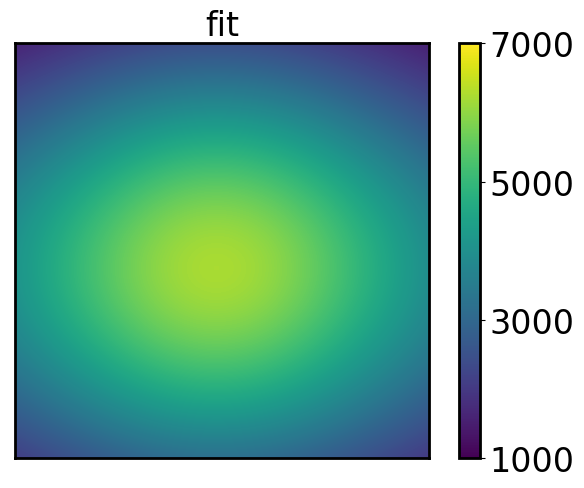

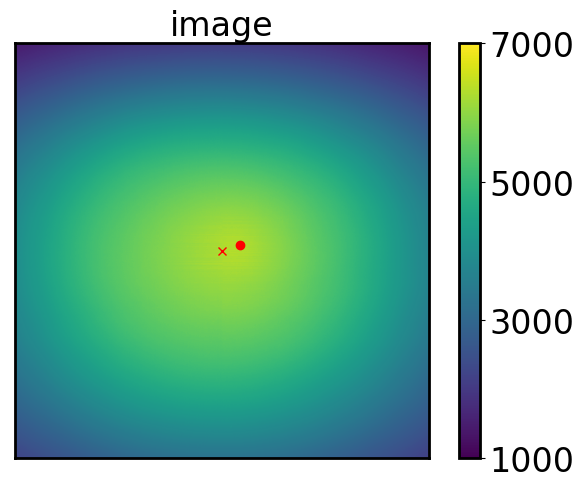

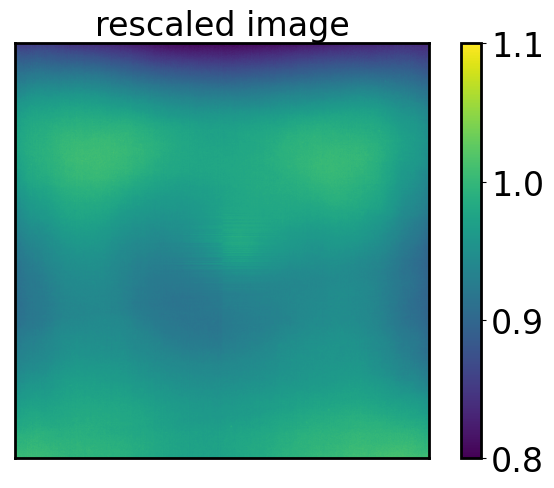

In [56]:
sheet = mean_mean
vmin = 1000
vmax = 7000
I0, xc, yc, xR, sigma_y = res.x
ygrid, xgrid = np.indices(sheet.shape)
I = sheet_intensity(xgrid, ygrid, I0, xc, yc, xR, sigma_y)
fontsize=24

plt.figure()
plt.imshow(I, vmin=vmin, vmax=vmax)
plt.title("fit", fontsize=fontsize)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_yticks([1000, 3000, 5000, 7000])
cbar.ax.set_yticklabels(labels=[1000, 3000, 5000, 7000],fontsize=24)
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/sheet_fit.pdf')

plt.figure()
plt.imshow(sheet, vmin=vmin, vmax=vmax)
plt.title('image', fontsize=fontsize)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_yticks([1000, 3000, 5000, 7000])
cbar.ax.set_yticklabels(labels=[1000, 3000, 5000, 7000],fontsize=24)
plt.plot(960, 960, 'rx')
plt.plot(yc, xc, 'ro')
scaled_sheet = sheet.astype('float32') / (I / np.max(I)) / np.max(sheet.astype('float32'))
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/sheet_mean.pdf')

plt.figure()
#plt.imshow(scaled_sheet, vmin=1000, vmax=9000)
plt.imshow(scaled_sheet, vmin=0.8, vmax=1.1)
plt.title('rescaled image', fontsize=fontsize)
cbar = plt.colorbar()
cbar.ax.set_yticks([0.8, 0.9, 1.0, 1.1])
cbar.ax.set_yticklabels(labels=[0.8, 0.9, 1.0, 1.1],fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/sheet_residuals.pdf')


# test rescaling on a real image

In [18]:
path_to_data = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_modified_earlyL3_timeseries/larvae_2/scan(3).czi'
data = AICSImage(path_to_data).get_image_data().squeeze()


In [6]:
#I0, xc, yc, xR, sigma_y  = [6227.21838549834, 931.5715074820621, 1040.3644589367918, 1290.8884641580382, 760.6163552682698]
I0, xc, yc, xR, sigma_y  = [53015.42534478,   958.02432563,   960.56444003,  1281.66615808, 749.00575153]

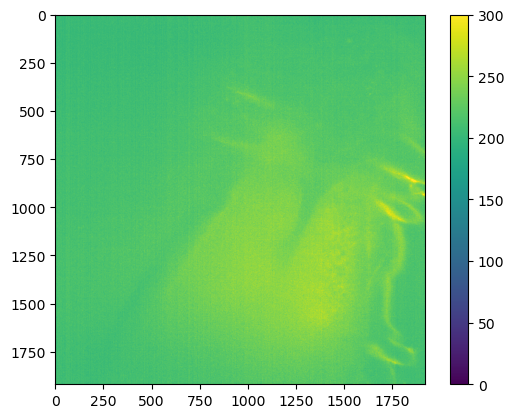

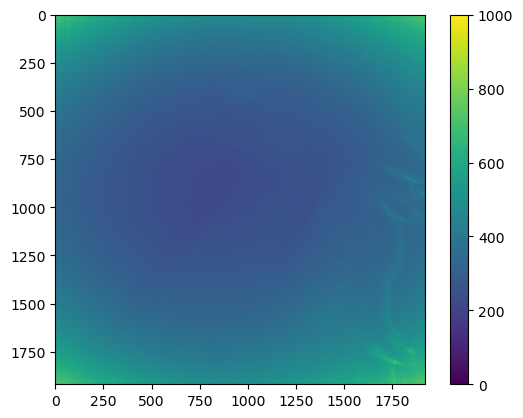

In [24]:
test_plane = data[0, 200]#250]
ygrid, xgrid = np.indices(test_plane.shape)
I = sheet_intensity(xgrid, ygrid, I0, xc, yc, xR, sigma_y)
plt.figure()
plt.imshow(test_plane, vmin=0, vmax=300)
plt.colorbar()
scaled_im = test_plane / (I / np.max(I))
plt.figure()
plt.imshow(scaled_im, vmin=0, vmax=1000)
plt.colorbar()

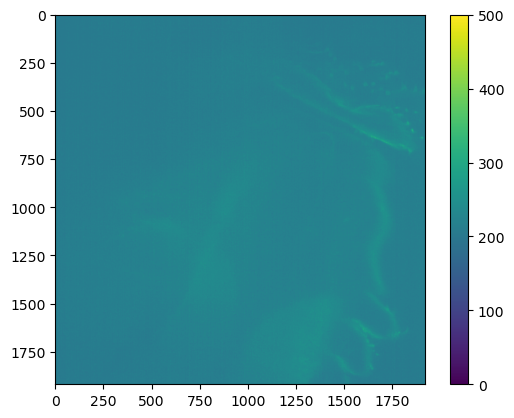

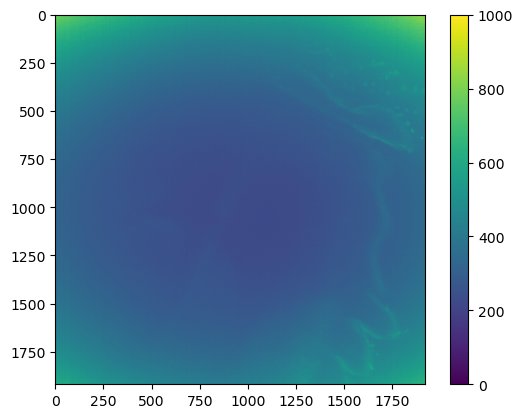

In [12]:
# green channel
test_plane = data[0, 100]#250]
ygrid, xgrid = np.indices(test_plane.shape)
I = sheet_intensity(xgrid, ygrid, I0, xc, yc, xR, sigma_y)
plt.figure()
plt.imshow(test_plane, vmin=0, vmax=500)
plt.colorbar()
scaled_im = test_plane / (I / np.max(I))
plt.figure()
plt.imshow(scaled_im, vmin=0, vmax=1000)
plt.colorbar()

In [20]:
print([I0, xc, yc, xR, sigma_y])

[7797.258205137989, 1026.9812202475537, 1037.778883204349, 1292.0834882978866, 762.7612416123233]


In [23]:
print([I0, xc, yc, xR, sigma_y])

[6227.21838549834, 931.5715074820621, 1040.3644589367918, 1290.8884641580382, 760.6163552682698]


# Green sheet

I forgot to save the two sheets separately. Need to manually assemble them differently.

In [11]:
im_dir = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/sheet_calibrations/2023_04_05_eGFP_1pct_gel/scan_1'
assemble_mean_sheet = True

In [12]:
if assemble_mean_sheet:
    data = AICSImage(im_dir + '/scan.czi', reader=readers.bioformats_reader.BioformatsReader).get_image_data().squeeze().astype('float32')
    sheet_0 = data[0]
    sheet_1 = data[1]
    mean_sheet = 0.5 * (sheet_0 + sheet_1)
    mean_sheet = mean_sheet.astype('uint16')
    mean_sheet_zarr = zarr.array(mean_sheet, chunks=(100, 1920, 1920), store=im_dir + '/mean_sheet.zarr')